# pyspark and machine learning: binary classification

In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession

Then, we need to configure SparkSession and sparkContext:

In [ ]:
spark = SparkSession.builder\
    .master("local[*]")\
    .appName("ML Term Deposit Pred")\
    .getOrCreate()
sc = spark.sparkContext


Next, we will import the dataset using read.csv function:

In [ ]:
df = spark.read.csv('/content/framingham_heart_disease.csv', header = True, inferSchema = True)
df.printSchema()


root
 |-- male: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- currentSmoker: integer (nullable = true)
 |-- cigsPerDay: string (nullable = true)
 |-- BPMeds: string (nullable = true)
 |-- prevalentStroke: integer (nullable = true)
 |-- prevalentHyp: integer (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- totChol: string (nullable = true)
 |-- sysBP: double (nullable = true)
 |-- diaBP: double (nullable = true)
 |-- BMI: string (nullable = true)
 |-- heartRate: string (nullable = true)
 |-- glucose: string (nullable = true)
 |-- TenYearCHD: integer (nullable = true)



In [ ]:
# Converting all the columns to numeric
from pyspark.sql.functions import col

df_numeric = df.select([col(c).cast("double").alias(c) for c in df.columns])
df_numeric.show(5)

+----+----+---------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+-----+---------+-------+----------+
|male| age|education|currentSmoker|cigsPerDay|BPMeds|prevalentStroke|prevalentHyp|diabetes|totChol|sysBP|diaBP|  BMI|heartRate|glucose|TenYearCHD|
+----+----+---------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+-----+---------+-------+----------+
| 1.0|39.0|      4.0|          0.0|       0.0|   0.0|            0.0|         0.0|     0.0|  195.0|106.0| 70.0|26.97|     80.0|   77.0|       0.0|
| 0.0|46.0|      2.0|          0.0|       0.0|   0.0|            0.0|         0.0|     0.0|  250.0|121.0| 81.0|28.73|     95.0|   76.0|       0.0|
| 1.0|48.0|      1.0|          1.0|      20.0|   0.0|            0.0|         0.0|     0.0|  245.0|127.5| 80.0|25.34|     75.0|   70.0|       0.0|
| 0.0|61.0|      3.0|          1.0|      30.0|   0.0|            0.0|         1.0|     0.0|  225.0|150.0| 95.0|28.58| 

Next, we can calculate summary statics for the numeric variables in the dataset:

In [ ]:
# Using the describe function to calculate the summary statistics of the numeric variables
df_numeric.describe().toPandas()


,summary,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,count,4238,4238,4133,4238,4209,4185,4238,4238,4238,4188,4238,4238,4219,4237,3850,4238
1,mean,0.42921189240207647,49.58494572911751,1.9789499153157513,0.49410099103350635,9.003088619624615,0.02962962962962963,0.005899008966493629,0.31052383199622463,0.025719679093912224,236.72158548233045,132.35240679565834,82.89346389806512,25.80200758473571,75.87892376681614,81.96675324675324,0.1519584709768759
2,stddev,0.49502208553649146,8.572159925118484,1.0197906893122037,0.5000241969070374,11.920093587827756,0.16958356790200058,0.07658717064585814,0.46276269567370154,0.15831642786899564,44.590334318749456,22.038096643544563,11.910849600225525,4.080111062409031,12.026596351612579,23.959998189237467,0.3590229919902725
3,min,0.0,32.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,83.5,48.0,15.54,44.0,40.0,0.0
4,max,1.0,70.0,4.0,1.0,70.0,1.0,1.0,1.0,1.0,696.0,295.0,142.5,56.8,143.0,394.0,1.0


Also, we can calculate and plot the correlations between the numeric variables:

In [ ]:
# import the scatter_matrix function

#from pandas.plotting import scatter_matrix

# converting the numeric features to Panadas dataframe and assigning them to variable
# numeric_data

#numeric_data = df_numeric.toPandas()

# using scatter_matrix function to visualize the correlations between the numeric variables
#axs = scatter_matrix(numeric_data, figsize = (15, 15))


We can see that currentSmoker, cigsPerDay, sysBP, diaBP, prevalentHyp Also, we can also use heatmap as another way of investigating the correlation between the numeric variables. For this, we will use seaborn package to generate the heatmap visualization:

In [ ]:
#import seaborn as sns
#import matplotlib.pyplot as plt

#fig = plt.figure(figsize = (15,10))
#sns.heatmap(numeric_data.corr(method = 'pearson'), annot = True, cmap = "Blues")
#plt.title("Correlation Heatmap")


In [ ]:
# Removing observations with null values
df = df_numeric
df = df.na.drop()

## Data Prep


In [ ]:
from pyspark.ml.feature import VectorAssembler

feature_columns = df.columns[:-1]

# using the VectorAssembler to combine all the feature columns into a single vector column
assemblerInputs = df.columns[:-1]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol = "features")
df_assembled = assembler.transform(df)

df_assembled = df_assembled.withColumnRenamed("TenYearCHD", "label")

Creating train and test using 70:30 split on assembled vectorized dataset

In [ ]:
train, test = df_assembled.randomSplit([0.7, 0.3], seed = 2022)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))


Training Dataset Count: 2527
Test Dataset Count: 1129


## Logistic Regression (LR) Model

First, we need to import the Logistic Regression classifier and set its parameters and train it using the training dataset using the fit function:


In [ ]:
# import LogisticRegression classifier
from pyspark.ml.classification import LogisticRegression
# configuring and training the Logistic Regression classifier using the training data
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

Now, we can calculate and plot the evaluation metrics (ROC, Area Under ROC curve, Precision and Recall) for the trained LR model.

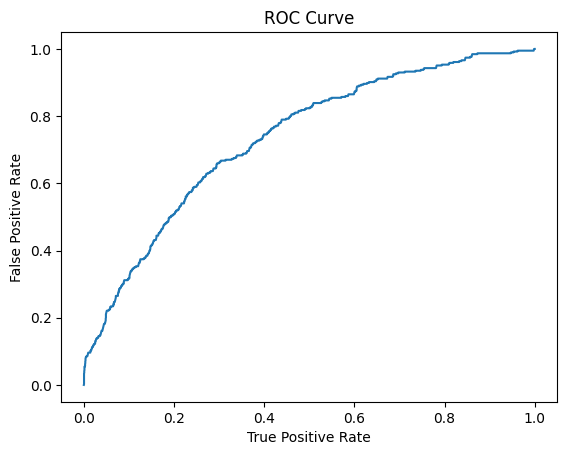

Training set Area Under ROC: 0.7344434743594429


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# calculate the statistics summary for the Logistic Regression model
trainingSummary = lrModel.summary
# plot the ROC curve from the calculated summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set Area Under ROC: ' + str(trainingSummary.areaUnderROC))


Also, we can calculate and plot the recall and precision for the Logistic Regression model:

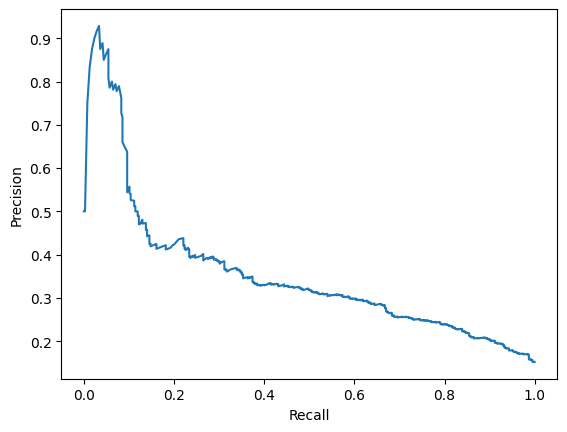

In [ ]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()


In [ ]:
# Testing the performance of the Logistic Regression classifier using the testing data
predictions = lrModel.transform(test)
predictions.select('label', 'prediction', 'rawPrediction', 'probability').show(10)

+-----+----------+--------------------+--------------------+
|label|prediction|       rawPrediction|         probability|
+-----+----------+--------------------+--------------------+
|  0.0|       0.0|[4.14169438207325...|[0.98435283080370...|
|  0.0|       0.0|[3.71921119731062...|[0.97632119305841...|
|  0.0|       0.0|[3.88066765340938...|[0.97978023397500...|
|  0.0|       0.0|[3.85221791313646...|[0.97920885771243...|
|  0.0|       0.0|[3.25238257048253...|[0.96275863265516...|
|  0.0|       0.0|[3.91868489740417...|[0.98051981190538...|
|  0.0|       0.0|[3.96161706132201...|[0.98132315066464...|
|  0.0|       0.0|[3.69686626708759...|[0.97579908499441...|
|  0.0|       0.0|[3.73562123241142...|[0.97669761153386...|
|  0.0|       0.0|[3.71737759340648...|[0.97627876653863...|
+-----+----------+--------------------+--------------------+
only showing top 10 rows



👉 Now, we can measure the performance of the LR model:

In [ ]:
# Import model evaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))


Test Area Under ROC 0.7459478505990115


In [ ]:
# compute TN, TP, FN, and FP
predictions.groupBy('label', 'prediction').count().show()


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|   15|
|  0.0|       1.0|    8|
|  1.0|       0.0|  157|
|  0.0|       0.0|  949|
+-----+----------+-----+



In [ ]:
# Calculate the elements of the confusion matrix
TN = 949
TP = 15
FN = 157
FP = 8

# Calculate accuracy, precision, recall, and F1-score
accuracy = (TP+TN)/(TP+TN+FP+FN)
sensitivity = (TP)/(TP+FN)
specificity = (TN)/(TN+FP)
precision = (TP)/(TP+FP)
recall = (TP)/(TP+FN)
F1_score = (2*precision*recall)/(precision+recall)

print('Accuracy: ', accuracy)
print('Sensitivity: ', sensitivity)
print('Specificity: ', specificity)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1-score: ', F1_score)

Accuracy:  0.853852967227635
Sensitivity:  0.0872093023255814
Specificity:  0.9916405433646813
Precision:  0.6521739130434783
Recall:  0.0872093023255814
F1-score:  0.15384615384615385


In [ ]:
# Calculate the elements of the confusion matrix
TN = predictions.filter('prediction = 1 AND label = 1').count()
TP = predictions.filter('prediction = 0 AND label = 0').count()
FN = predictions.filter('prediction = 0 AND label = 1').count()
FP = predictions.filter('prediction = 1 AND label = 0').count()

# Calculate accuracy, precision, recall, and F1-score
accuracy = (TP+TN)/(TP+TN+FP+FN)
sensitivity = (TP)/(TP+FN)
specificity = (TN)/(TN+FP)
precision = (TP)/(TP+FP)
recall = (TP)/(TP+FN)
F1_score = (2*precision*recall)/(precision+recall)

print('Accuracy: ', accuracy)
print('Sensitivity: ', sensitivity)
print('Specificity: ', specificity)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1-score: ', F1_score)

## Gradient-Boosted Tree (GBT) Model

In [ ]:
# import the Gradient-Boosted Tree classifier
from pyspark.ml.classification import GBTClassifier

# configuring and training the Gradient-Boosted Tree classifier using the training data
gbt = GBTClassifier(maxIter=10)

gbtModel = gbt.fit(train)

predictions = gbtModel.transform(test)
predictions.select('label', 'prediction').show(10)

#from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))



+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 10 rows

Test Area Under ROC 0.7037131539938262


explainParams() returns the documentation of all params with their optionally default values and user-supplied values.

In [ ]:
print(gbt.explainParams())

👉 Now, we can try to re-configure some of the parameters to improve the GBT model performance using ParamGridBuilder and CrossValidator.

⚠ Warning: This might take a while to run

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)


✏️ We can also calculate other evaluation metrics (precision, recall, accuracy and F score) to evaluate each of the models developed above using the following code. See the formulas in the lab brief.


In [ ]:
# compute TN, TP, FN, and FP
predictions.groupBy('label', 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN = predictions.filter('prediction = 0 AND label = prediction').count()
TP = predictions.filter('prediction = 1 AND label = prediction').count()
FN = predictions.filter('prediction = 0 AND label <> prediction').count()
FP = predictions.filter('prediction = 1 AND label <> prediction').count()

# Calculate accuracy, precision, recall, and F1-score
accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = (TP)/(TP+FP)
recall = (TP)/(TP+FN)
F1_score = (2*precision*recall)/(precision+recall)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1-score: ', F1_score)
